# section two

造成劳动力供给增加

两部门：还可以转而去服务业创业

稳妥的结果：500 * 40

Section1：250 * 20

In [1]:
# parameters setting

# tech
alpha=0.3
theta=0.49
fc_m=4.68
fc_s=0

# depreciation
delta=0.06

# describing the process for entrepreneurial talent
gamma=0.89
eta=4.84

# discount factor
beta=0.92

# relative risk aversion
sigma=1.5

# intratemporal elasticity of substitution
epsilon=1

# service share in consumption
psi=0.91

In [2]:
# import packages
import timeit
import numpy as np
from numba import njit,prange
import numba
import matplotlib.pyplot as plt

In [3]:
# talent probability
from scipy.stats import pareto
def discrete_pareto(shape,lower_bound,upper_bound,grid_numder):
    ability=np.linspace(pareto.ppf(lower_bound,shape),pareto.ppf(upper_bound,shape),(grid_numder+1))  # 可以从60%开始取点，但是没改全！！！
    probability=np.diff(pareto.cdf(ability,shape)) / (upper_bound-lower_bound)
    zgrid = ability[1:]
    return zgrid,probability

In [4]:
# add kgrid to 250
kmin = 0
kmax = 150
n_k = 250
kgrid = np.linspace(kmin, kmax, n_k)
zgrid,p_z = discrete_pareto(4.84,0.6,0.995,40)
n_z = len(zgrid)
V0 = np.zeros((n_k, n_z))
P=np.zeros((n_z, n_z))
for i in range(n_z):
    for j in range(n_z):
        if j==i:
            P[i,j]=gamma+(1-gamma)*p_z[j]
        else:
            P[i,j]=(1-gamma)*p_z[j]

In [5]:
def u(c):
    if c > 0:
        res = (c**(1-sigma))/(1-sigma)
    else:
        res = -np.inf
    return res
if compile:
    u = njit(u)

def budget_worker(a, x, w, r):
    return w + (1+r)*a - x
if compile:
    budget_worker = njit(budget_worker)

def f(z_index, k, l):
    return zgrid[z_index]*(k**alpha)*(l**theta)
if compile:
    f = njit(f)

def budget_entrepreneur(z_index, k, l, a , x , w, r): # add fixed cost fc_m
    R = r + delta
    return f(z_index, k, l) + (1+r)*a - R*k - w*l - x - (1+r)*fc_m
if compile:
    budget_entrepreneur = njit(budget_entrepreneur)

In [6]:
def V_current_worker(k_next_index, k_index, z_index, V_next, w, r):
    c = budget_worker(kgrid[k_index], kgrid[k_next_index], w, r)
    EV = np.sum(P[z_index,:]*V_next[k_next_index,:]) # expectation
    res = u(c) + beta*(gamma*V_next[k_next_index,z_index]+(1-gamma)*EV)
    return res
if compile:
    V_current_worker = njit(V_current_worker)
    
def V_max_worker(k_index, z_index, k_start, V, w, r):
    V_max = -np.inf
    for j in range(k_start,n_k):
        k_next = kgrid[j]
        V_new=V_current_worker(j,k_index,z_index, V, w, r)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:break
    return V_max, g_k, k_start
if compile:
    V_max_worker = njit(V_max_worker)

# def V_update_worker(V, w, r):
#     V_new = np.zeros((n_k, n_z))
#     g_new = np.zeros((n_k, n_z))
#     for i_z in range(n_z): 
#         k_start = 0
#         for i_k in range(k_start,n_k): # loop over all state k
#             V_new[i_k, i_z], g_new[i_k, i_z] ,k_start= V_max_worker(i_k, i_z,k_start,V,w,r)
#     return V_new, g_new
# if compile:
#     V_update_worker = njit(V_update_worker, parallel=True)

In [7]:
def V_current_entrepreneur(k_next_index, k_index, z_index, V_next, k, l, w, r):
    c = budget_entrepreneur(z_index, k, l, kgrid[k_index], kgrid[k_next_index], w, r)
    EV = np.sum(P[z_index,:]*V_next[k_next_index,:]) # expectation
    res = u(c) + beta*(gamma*V_next[k_next_index,z_index]+(1-gamma)*EV)
    return res
if compile:
    V_current_entrepreneur = njit(V_current_entrepreneur)

def V_max_entrepreneur(k_index, z_index, k_start, V ,w, r):
    R=r+delta
    k=((R/alpha/zgrid[z_index])*(w*alpha/R/theta)**theta)**(1/(alpha+theta-1))
    l=k*(theta/alpha)*(R/w)
    V_max = -np.inf
    for j in range(k_start,n_k):
        k_next = kgrid[j]
        V_new=V_current_entrepreneur(j,k_index,z_index, V, k,l,w, r)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:break
    return V_max, g_k, k_start
if compile:
    V_max_entrepreneur = njit(V_max_entrepreneur)

# def V_update_entrepreneur(V, w, r):
#     V_new = np.zeros((n_k, n_z))
#     g_new = np.zeros((n_k, n_z))
#     for i_z in range(n_z): 
#         k_start = 0
#         for i_k in range(k_start,n_k): # loop over all state k
#             V_new[i_k, i_z], g_new[i_k, i_z] ,k_start= V_max_entrepreneur(i_k, i_z,k_start, V, w, r)
#     return V_new, g_new
# if compile:
#     V_update_entrepreneur = njit(V_update_entrepreneur, parallel=True)

In [8]:
def V_update(V, w, r): # 放到一起
    V_new = np.zeros((n_k, n_z))
    g_new = np.zeros((n_k, n_z))
    state_new = np.zeros((n_k, n_z))
    # V_worker,g_worker=V_update_worker(V, w, r)
    # V_entrepreneur,g_entrepreneur=V_update_entrepreneur(V, w, r)
    for i_z in prange(n_z):
        k_start_worker=0
        k_start_entrepreneur=0
        for i_k in range(n_k):
            V_new_worker, g_new_worker,k_start_worker= V_max_worker(i_k, i_z,k_start_worker,V,w,r)
            V_new_entrepreneur, g_new_entrepreneur,k_start_entrepreneur= V_max_entrepreneur(i_k, i_z,k_start_entrepreneur,V,w,r)
            if V_new_worker>=V_new_entrepreneur:
                V_new[i_k, i_z]=V_new_worker
                g_new[i_k, i_z]=g_new_worker
            else:
                V_new[i_k, i_z]=V_new_entrepreneur
                g_new[i_k, i_z]=g_new_entrepreneur
                state_new[i_k, i_z]=1
    return V_new, g_new, state_new
if compile:
    V_update = njit(V_update,parallel=True)

def V_iteration(V_initial,tol,w,r):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    # print_skip = 50
    while count < max_iter and error > tol:
        V_new, g_new, state_new = V_update(V, w, r)
        error = np.max(np.abs(V_new - V))
        V = V_new
        count = count + 1
        # if count % print_skip == 0:
        #     print(f"Error at iteration {count} is {error}.")
    # if error > tol:
    #     print("Failed to converge!")
    # else:
    #      print(f"\nConverged in {count} iterations.")
    return V_new, g_new, state_new

In [9]:
start_time = timeit.default_timer()
V, g , state_entrepreneur= V_iteration(V0,tol=1e-7,w=0.5,r=0.08)
print("The time difference is :", timeit.default_timer() - start_time)

The time difference is : 6.0325249999878


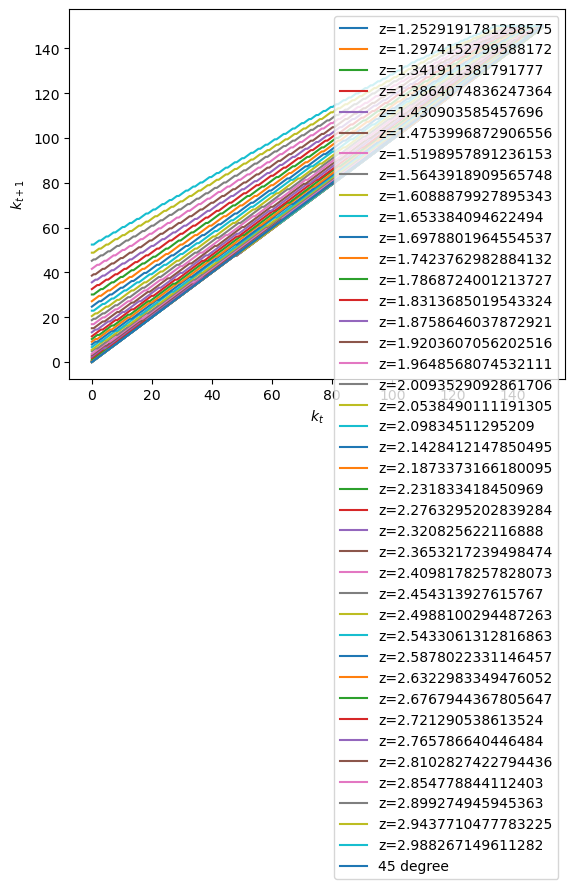

In [10]:
for i in range (n_z):
    plt.plot(kgrid,g[:,i],label='z='+ str(zgrid[i]))
plt.plot(kgrid,kgrid,label="45 degree")
plt.xlabel("$k_t$")
plt.ylabel("$k_{t+1}$")
# plt.title('policy function,$w=0.9,r=0.05$')
plt.legend()

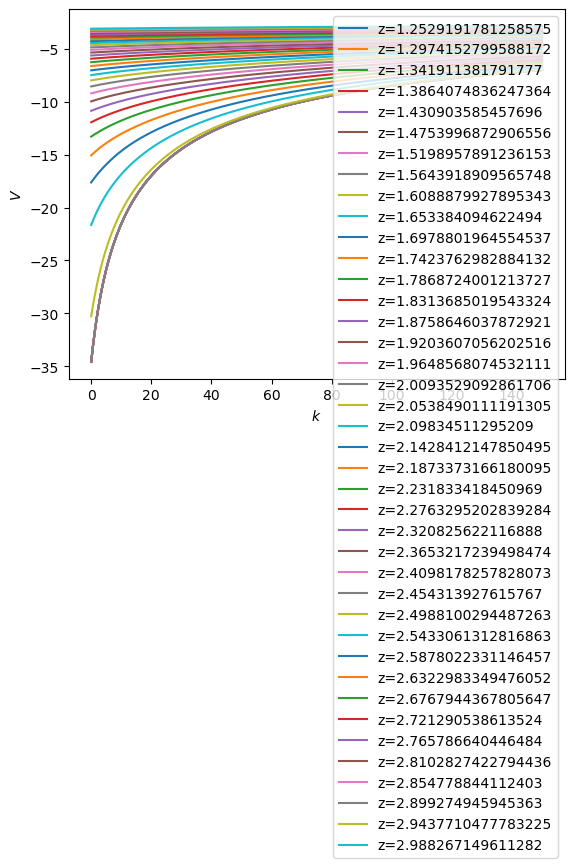

In [11]:
for i in range (n_z):
    plt.plot(kgrid,V[:,i],label='z='+ str(zgrid[i]))
plt.xlabel("$k$")
plt.ylabel("$V$")
# plt.title('value function,$w=0.9,r=0.05$')
plt.legend()

In [12]:
state_entrepreneur

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [13]:
np.sum(state_entrepreneur)

8000.0

In [14]:

from scipy import sparse

def transQ_sparse(g):
    n_k, n_s = g.shape
    n = n_k * n_s
    row_indices = []
    col_indices = []
    values = []

    for j in numba.prange(n):
        i_k = j // n_s
        i_s = j % n_s
        diff = np.abs(g[i_k, i_s] - kgrid)
        mark = np.argmin(diff)
        j_prime_start = mark * n_s
        
        row = np.full(n_s, j)
        col = np.arange(j_prime_start, j_prime_start + n_s)
        val = P[i_s, :]
        
        row_indices.extend(row)
        col_indices.extend(col)
        values.extend(val)

    Q = sparse.csr_matrix((values, (row_indices, col_indices)), shape=(n, n))
    return Q

In [15]:
# Asset's Stable Distribution
def transQ(g):
    n_k, n_z = g.shape
    n = n_k * n_z
    Q = np.zeros((n, n))
    for j in numba.prange(n):
        i_k = j // n_z
        i_s = j % n_z
        diff = np.abs(g[i_k, i_s] - kgrid)
        mark = np.argmin(diff)
        j_prime_start = mark * n_z
        j_prime_end = j_prime_start + n_z
        Q[j, j_prime_start:j_prime_end] = P[i_s, :]
    return Q
if compile:
    transQ=njit(transQ,parallel=True)

@njit
def capital_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_z))
    k_marginal = tmp.sum(axis=1)
    return k_marginal
@njit
def state_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_z))
    s_marginal = tmp.sum(axis=0)
    return s_marginal

# 0是列(given z)，1是行(given k)

In [16]:
def pristine_stationary_distribution_iteration(P, psi0, tol):
    err = np.inf
    max_iter = 1000
    iter = 0
    print_skip = 500
    while iter < max_iter and err > tol:
        psi = np.dot(P.T,psi0)
        err = np.max(np.abs(psi - psi0))
        iter = iter + 1
        # if iter % print_skip == 0:
        #     print(f"Error at iteration {iter}:", err)
        #     print(np.sum(psi))
        psi0 = psi
    # if err > tol:
    #     print("Failed to converge!")
    # else:
    #     print(f"\nConverged in {iter} iterations.")
    return psi0


import scipy.sparse as sp

def sparse_stationary_distribution_iteration(P, psi0, tol):
    P_csc = sp.csc_matrix(P.T)
    err = np.inf
    max_iter = 1000
    iter = 0
    print_skip = 50
    
    while iter < max_iter and err > tol:
        psi = P_csc.dot(psi0)
        err = np.max(np.abs(psi - psi0))
        iter = iter + 1
        psi0 = psi
        
    return psi0


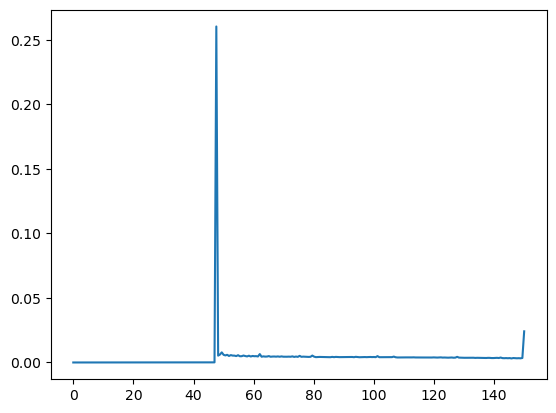

In [17]:
Q = transQ_sparse(g)
psi0 = np.ones((n_k * n_z))/(n_k * n_z)
tol = 1e-5

ss = sparse_stationary_distribution_iteration(Q, psi0, tol)
a_dist=capital_marginal(ss)
plt.plot(kgrid,a_dist)

In [18]:
# Compute Demand and Supply in Capital Market
def capital_and_labor(w,r):
    V0 = np.zeros((n_k, n_z))
    V_new,g,state_entrepreneur=V_iteration(V0,1e-7,w,r)
    Q=transQ_sparse(g)
    psi0 = np.ones((n_k * n_z))/(n_k * n_z)
    ss=sparse_stationary_distribution_iteration(Q,psi0,10e-5)
    # ss=stationary_distribution(Q)
    tmp = ss.reshape((n_k, n_z))
    a_dist=capital_marginal(ss)
    z_dist=state_marginal(ss)
## capital_supply
    capital_supply=np.dot(kgrid,a_dist)
## labor_supply
    state_worker=np.ones((n_k, n_z))-state_entrepreneur
    labor_supply_joint=np.zeros((n_k, n_z))            
## capital_demand & labor_demand
    R=r+delta
    capital_demand_joint= np.zeros((n_k, n_z))
    labor_demand_joint= np.zeros((n_k, n_z))
    for i_k in range(n_k):
        for i_z in range(n_z):
            capital_demand_joint[i_k,i_z]=state_entrepreneur[i_k,i_z]*((R/alpha/zgrid[i_z])*(w*alpha/R/theta)**theta)**(1/(alpha+theta-1))*tmp[i_k,i_z] 
            #capital_demand_joint 这里已经乘以概率了
            labor_demand_joint[i_k,i_z]=capital_demand_joint[i_k,i_z]*(theta/alpha)*(R/w)
            labor_supply_joint[i_k,i_z]=state_worker[i_k,i_z]*tmp[i_k,i_z]
    labor_supply=np.sum(labor_supply_joint)
    capital_demand=np.sum(capital_demand_joint)
    labor_demand=np.sum(labor_demand_joint)
    
    return capital_supply,capital_demand,labor_supply,labor_demand

In [19]:
capital_and_labor(0.9,0.08)

(51.457299386406774,
 6.0924509045307484,
 0.9493571144848334,
 1.5479338224104053)

## compute

In [20]:
def equilibrium_k(w,r):
    a_supply,a_demand,l_supply,l_demand=capital_and_labor(w,r)
    res_k=a_supply-a_demand
    print('w=',w,'r=,',r,'capital supply=',a_supply,'capital demand=',a_demand,'res_k=',res_k)
    return res_k
    
def equilibrium_l(w,r):
    a_supply,a_demand,l_supply,l_demand=capital_and_labor(w,r)
    res_l=l_supply-l_demand
    print('w=',w,'r=,',r,'labor supply=',l_supply,'labor demand=',l_demand,'res_l=',res_l)
    return res_l

In [21]:
import scipy.optimize as optimize

def w_update(r):
    wmax=1.5
    wmin=0.5
    start_time = timeit.default_timer()
    solution = optimize.root_scalar(
    f=equilibrium_l, bracket=[wmin,wmax], args=(r), method="bisect", xtol=1e-5
    )
    print("The time difference is :", timeit.default_timer() - start_time)
    print("final w=", solution.root)
    return solution.root

# def r_update(w):
#     start_time = timeit.default_timer()
#     solution = optimize.root_scalar(
#     f=equilibrium_k, bracket=[rmin,rmax], args=(w), method="bisect", xtol=1e-7
#     )
#     print("The time difference is :", timeit.default_timer() - start_time)
#     print("final r=", solution.root)
#     return solution.root

## plot

In [25]:
### plot market curves
from tqdm import tqdm

def labor_curve(wmin, wmax, wgrid_number,r):
    wgrid = np.linspace(wmin, wmax, wgrid_number)
    l_supply = np.zeros(wgrid_number)
    l_demand = np.zeros(wgrid_number)
    for i in tqdm(range(wgrid_number)):
        w0 = wgrid[i]
        capital_supply,capital_demand,l_supply[i],l_demand[i]=capital_and_labor(w0,r) #capital 只是为了占位
    return wgrid, l_supply, l_demand

wgrid, labor_supply, labor_demand = labor_curve(
    wmin=0.5, wmax=1.5, wgrid_number=50,r=0.082
)

100%|██████████| 50/50 [01:29<00:00,  1.78s/it]


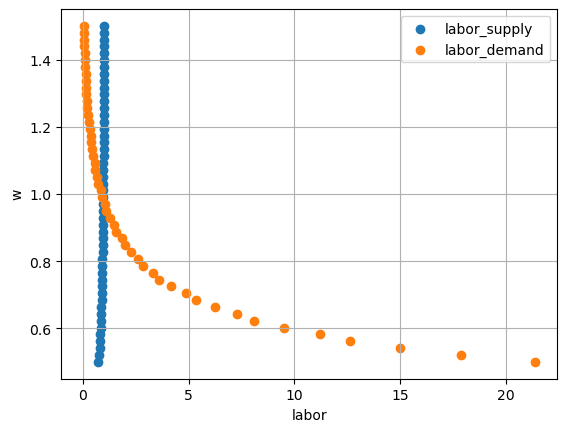

In [26]:
# Plot
plt.scatter(labor_supply,wgrid,label="labor_supply")
plt.scatter(labor_demand,wgrid,label="labor_demand")
# plt.title('labor market with r=0.082')
plt.ylabel('w')
plt.xlabel('labor')
plt.legend()
plt.grid(True)

In [27]:
from tqdm import tqdm

def capital_curve(rmin, rmax, rgrid_number):
    rgrid = np.linspace(rmin, rmax, rgrid_number)
    a_supply = np.zeros(rgrid_number)
    a_demand = np.zeros(rgrid_number)
    for i in tqdm(range(rgrid_number)):
        r0 = rgrid[i]
        w = w_update(r0)
        a_supply[i],a_demand[i],l_supply,l_demand=capital_and_labor(w,r0) #labor 只是为了占位
    return rgrid, a_supply, a_demand

rgrid, capital_supply, capital_demand = capital_curve(
    rmin=0.03, rmax=0.082, rgrid_number=20
)


  0%|          | 0/20 [00:00<?, ?it/s]

w= 0.5 r=, 0.03 labor supply= 0.49188070241454623 labor demand= 49.06775162693223 res_l= -48.57587092451768
w= 1.5 r=, 0.03 labor supply= 0.9795132988939743 labor demand= 0.31670929317736746 res_l= 0.6628040057166069
w= 1.0 r=, 0.03 labor supply= 0.9163323314706215 labor demand= 2.5968734869583203 res_l= -1.6805411554876988
w= 1.25 r=, 0.03 labor supply= 0.9605746246509653 labor demand= 0.8548335347778221 res_l= 0.10574108987314323
w= 1.125 r=, 0.03 labor supply= 0.9425508500344812 labor demand= 1.4736294296981625 res_l= -0.5310785796636812
w= 1.1875 r=, 0.03 labor supply= 0.9492891969499835 labor demand= 1.1570048195816993 res_l= -0.20771562263171583
w= 1.21875 r=, 0.03 labor supply= 0.9552689363888861 labor demand= 0.9947677790429107 res_l= -0.03949884265402459
w= 1.234375 r=, 0.03 labor supply= 0.9552588135053449 labor demand= 0.9536847686457266 res_l= 0.0015740448596183176
w= 1.2265625 r=, 0.03 labor supply= 0.9552689363888864 labor demand= 0.973803945142823 res_l= -0.0185350087539

  5%|▌         | 1/20 [00:32<10:12, 32.24s/it]

w= 0.5 r=, 0.032736842105263154 labor supply= 0.49188126359558326 labor demand= 47.011890198055326 res_l= -46.520008934459746
w= 1.5 r=, 0.032736842105263154 labor supply= 0.9796091053499508 labor demand= 0.3018858459125543 res_l= 0.6777232594373965
w= 1.0 r=, 0.032736842105263154 labor supply= 0.9163363712318393 labor demand= 2.487899383215069 res_l= -1.5715630119832298
w= 1.25 r=, 0.032736842105263154 labor supply= 0.9605950779893345 labor demand= 0.8184998451003433 res_l= 0.14209523288899117
w= 1.125 r=, 0.032736842105263154 labor supply= 0.9425590735405194 labor demand= 1.4116212695674717 res_l= -0.4690621960269523
w= 1.1875 r=, 0.032736842105263154 labor supply= 0.9553051044127234 labor demand= 1.0382300420841089 res_l= -0.08292493767138542
w= 1.21875 r=, 0.032736842105263154 labor supply= 0.9552931004103828 labor demand= 0.9524415250734574 res_l= 0.0028515753369254826
w= 1.203125 r=, 0.032736842105263154 labor supply= 0.9552994517343729 labor demand= 0.9941217160873641 res_l= -0.

 10%|█         | 2/20 [01:06<10:03, 33.52s/it]

w= 0.5 r=, 0.03547368421052632 labor supply= 0.49188168091587536 labor demand= 45.09834831171824 res_l= -44.606466630802366
w= 1.5 r=, 0.03547368421052632 labor supply= 0.9824046602857391 labor demand= 0.2623323688935469 res_l= 0.7200722913921922
w= 1.0 r=, 0.03547368421052632 labor supply= 0.9262323210768101 labor demand= 2.2558674544003567 res_l= -1.3296351333235465
w= 1.25 r=, 0.03547368421052632 labor supply= 0.9653580208214871 labor demand= 0.7307325702679183 res_l= 0.23462545055356887
w= 1.125 r=, 0.03547368421052632 labor supply= 0.9493359366370576 labor demand= 1.2718895862240802 res_l= -0.3225536495870226
w= 1.1875 r=, 0.03547368421052632 labor supply= 0.9553185977459787 labor demand= 0.9955939104530374 res_l= -0.04027531270705864
w= 1.21875 r=, 0.03547368421052632 labor supply= 0.960629490229504 labor demand= 0.8534099814774616 res_l= 0.10721950875204234
w= 1.203125 r=, 0.03547368421052632 labor supply= 0.955310135296454 labor demand= 0.9533731251429527 res_l= 0.0019370101535

 15%|█▌        | 3/20 [01:40<09:30, 33.53s/it]

w= 0.5 r=, 0.03821052631578947 labor supply= 0.49188191395000763 labor demand= 43.31363025030724 res_l= -42.82174833635723
w= 1.5 r=, 0.03821052631578947 labor supply= 0.9824539023200599 labor demand= 0.25119054049593287 res_l= 0.7312633618241271
w= 1.0 r=, 0.03821052631578947 labor supply= 0.9262342670335041 labor demand= 2.1665155941526097 res_l= -1.2402813271191055
w= 1.25 r=, 0.03821052631578947 labor supply= 0.9653733771950681 labor demand= 0.7014439502604758 res_l= 0.2639294269345923
w= 1.125 r=, 0.03821052631578947 labor supply= 0.9493438270327249 labor demand= 1.2213096398346608 res_l= -0.2719658128019359
w= 1.1875 r=, 0.03821052631578947 labor supply= 0.9606513791275609 labor demand= 0.8931589720528327 res_l= 0.06749240707472826
w= 1.15625 r=, 0.03821052631578947 labor supply= 0.9553328356097547 labor demand= 1.044667025968254 res_l= -0.08933419035849932
w= 1.171875 r=, 0.03821052631578947 labor supply= 0.9553306103827246 labor demand= 0.9990185528074064 res_l= -0.043687942424

 20%|██        | 4/20 [02:11<08:40, 32.53s/it]

w= 0.5 r=, 0.040947368421052635 labor supply= 0.5657185986021115 labor demand= 39.84367985979098 res_l= -39.27796126118887
w= 1.5 r=, 0.040947368421052635 labor supply= 0.9849676943641331 labor demand= 0.2169196289611104 res_l= 0.7680480654030227
w= 1.0 r=, 0.040947368421052635 labor supply= 0.9349288286307958 labor demand= 1.965346183311917 res_l= -1.0304173546811213
w= 1.25 r=, 0.040947368421052635 labor supply= 0.9653870484306363 labor demand= 0.6741160779770748 res_l= 0.29127097045356143
w= 1.125 r=, 0.040947368421052635 labor supply= 0.9553418920137329 labor demand= 1.1002143505969504 res_l= -0.1448724585832175
w= 1.1875 r=, 0.040947368421052635 labor supply= 0.9606577595208786 labor demand= 0.8585966629669926 res_l= 0.10206109655388607
w= 1.15625 r=, 0.040947368421052635 labor supply= 0.9553395435375268 labor demand= 1.0042509150176824 res_l= -0.04891137148015556
w= 1.171875 r=, 0.040947368421052635 labor supply= 0.9606594365573428 labor demand= 0.8973065081637308 res_l= 0.063352

 25%|██▌       | 5/20 [02:42<08:01, 32.07s/it]

w= 0.5 r=, 0.04368421052631579 labor supply= 0.5657186814490612 labor demand= 38.34973961881385 res_l= -37.78402093736479
w= 1.5 r=, 0.04368421052631579 labor supply= 0.9849927929841331 labor demand= 0.20841547642870453 res_l= 0.7765773165554286
w= 1.0 r=, 0.04368421052631579 labor supply= 0.9349299359603958 labor demand= 1.8916116394541211 res_l= -0.9566817034937254
w= 1.25 r=, 0.04368421052631579 labor supply= 0.9696223508924403 labor demand= 0.6018097620722289 res_l= 0.3678125888202114
w= 1.125 r=, 0.04368421052631579 labor supply= 0.9553458432673503 labor demand= 1.058843781210551 res_l= -0.10349793794320061
w= 1.1875 r=, 0.04368421052631579 labor supply= 0.9606644919693528 labor demand= 0.8262301163850515 res_l= 0.13443437558430127
w= 1.15625 r=, 0.04368421052631579 labor supply= 0.9606662618922296 labor demand= 0.9029905106427903 res_l= 0.057675751249439244
w= 1.140625 r=, 0.04368421052631579 labor supply= 0.9553452257283368 labor demand= 1.0112805166614838 res_l= -0.055935290933

 30%|███       | 6/20 [03:13<07:24, 31.75s/it]

w= 0.5 r=, 0.046421052631578946 labor supply= 0.565718727097158 labor demand= 36.948601989082874 res_l= -36.38288326198572
w= 1.5 r=, 0.046421052631578946 labor supply= 0.9872379224255019 labor demand= 0.17879342489999567 res_l= 0.8084444975255063
w= 1.0 r=, 0.046421052631578946 labor supply= 0.9349305542998284 labor demand= 1.8224765472704885 res_l= -0.8875459929706601
w= 1.25 r=, 0.046421052631578946 labor supply= 0.9696283669835566 labor demand= 0.5796883150683008 res_l= 0.3899400519152558
w= 1.125 r=, 0.046421052631578946 labor supply= 0.9553480496708602 labor demand= 1.0200946108390285 res_l= -0.06474656116816835
w= 1.1875 r=, 0.046421052631578946 labor supply= 0.9654055667229959 labor demand= 0.7412250007014194 res_l= 0.22418056602157654
w= 1.15625 r=, 0.046421052631578946 labor supply= 0.9606692397440615 labor demand= 0.8699183592249135 res_l= 0.09075088051914804
w= 1.140625 r=, 0.046421052631578946 labor supply= 0.9606700226045765 labor demand= 0.9102570356992808 res_l= 0.05041

 35%|███▌      | 7/20 [03:44<06:50, 31.60s/it]

w= 0.5 r=, 0.04915789473684211 labor supply= 0.5657187175946783 labor demand= 35.63233996450949 res_l= -35.06662124691481
w= 1.5 r=, 0.04915789473684211 labor supply= 0.98724733482478 labor demand= 0.17229043360501262 res_l= 0.8149569012197674
w= 1.0 r=, 0.04915789473684211 labor supply= 0.9425900723308122 labor demand= 1.654856533657986 res_l= -0.7122664613271737
w= 1.25 r=, 0.04915789473684211 labor supply= 0.9734105922277164 labor demand= 0.516369576411375 res_l= 0.4570410158163414
w= 1.125 r=, 0.04915789473684211 labor supply= 0.9606716860178491 labor demand= 0.9190847845628879 res_l= 0.041586901454961245
w= 1.0625 r=, 0.04915789473684211 labor supply= 0.9493563930693018 labor demand= 1.2701711744857502 res_l= -0.3208147814164485
w= 1.09375 r=, 0.04915789473684211 labor supply= 0.9553498622080114 labor demand= 1.0805524824395807 res_l= -0.12520262023156925
w= 1.109375 r=, 0.04915789473684211 labor supply= 0.9553497413920005 labor demand= 1.0306542436402755 res_l= -0.075304502248275

 40%|████      | 8/20 [04:15<06:15, 31.33s/it]

w= 0.5 r=, 0.051894736842105264 labor supply= 0.6272863192161633 labor demand= 32.89308059407192 res_l= -32.26579427485576
w= 1.5 r=, 0.051894736842105264 labor supply= 0.9892661855855082 labor demand= 0.1463733239357409 res_l= 0.8428928616497673
w= 1.0 r=, 0.051894736842105264 labor supply= 0.9425902579329813 labor demand= 1.5973307536133372 res_l= -0.6547404956803559
w= 1.25 r=, 0.051894736842105264 labor supply= 0.9734123769218408 labor demand= 0.4983836334939943 res_l= 0.4750287434278465
w= 1.125 r=, 0.051894736842105264 labor supply= 0.9606724217677441 labor demand= 0.8871192080484779 res_l= 0.07355321371926626
w= 1.0625 r=, 0.051894736842105264 labor supply= 0.9553505349145195 labor demand= 1.1487822815644047 res_l= -0.19343174664988516
w= 1.09375 r=, 0.051894736842105264 labor supply= 0.9553504073530502 labor demand= 1.0429789586154279 res_l= -0.08762855126237767
w= 1.109375 r=, 0.051894736842105264 labor supply= 0.9606725430855368 labor demand= 0.9294531232725425 res_l= 0.03121

 45%|████▌     | 9/20 [04:46<05:44, 31.31s/it]

w= 0.5 r=, 0.05463157894736842 labor supply= 0.6272863329307645 labor demand= 31.776947362704384 res_l= -31.14966102977362
w= 1.5 r=, 0.05463157894736842 labor supply= 0.9892690319559907 labor demand= 0.1413676222886806 res_l= 0.8479014096673101
w= 1.0 r=, 0.05463157894736842 labor supply= 0.9493570589347586 labor demand= 1.449646099748664 res_l= -0.5002890408139054
w= 1.25 r=, 0.05463157894736842 labor supply= 0.9767984858853578 labor demand= 0.44257231078142417 res_l= 0.5342261751039337
w= 1.125 r=, 0.05463157894736842 labor supply= 0.9654098532091681 labor demand= 0.7980797361859139 res_l= 0.16733011702325418
w= 1.0625 r=, 0.05463157894736842 labor supply= 0.9553507329290419 labor demand= 1.1097955383007978 res_l= -0.15444480537175587
w= 1.09375 r=, 0.05463157894736842 labor supply= 0.960672843364688 labor demand= 0.9413810686723921 res_l= 0.019291774692295816
w= 1.078125 r=, 0.05463157894736842 labor supply= 0.9553507049001181 labor demand= 1.0570837435256306 res_l= -0.101733038625

 50%|█████     | 10/20 [05:17<05:12, 31.21s/it]

w= 0.5 r=, 0.05736842105263158 labor supply= 0.627286336536256 labor demand= 30.72370618155315 res_l= -30.096419845016896
w= 1.5 r=, 0.05736842105263158 labor supply= 0.9910927513300956 labor demand= 0.11848922592626555 res_l= 0.87260352540383
w= 1.0 r=, 0.05736842105263158 labor supply= 0.9493570971710898 labor demand= 1.4015965086311821 res_l= -0.4522394114600923
w= 1.25 r=, 0.05736842105263158 labor supply= 0.9767989066835783 labor demand= 0.4278946667949597 res_l= 0.5489042398886186
w= 1.125 r=, 0.05736842105263158 labor supply= 0.9654099946017072 labor demand= 0.7716237790356735 res_l= 0.1937862155660337
w= 1.0625 r=, 0.05736842105263158 labor supply= 0.9553508023046979 labor demand= 1.0730094913748367 res_l= -0.11765868907013877
w= 1.09375 r=, 0.05736842105263158 labor supply= 0.9606729485694121 labor demand= 0.9101762001476895 res_l= 0.05049674842172258
w= 1.078125 r=, 0.05736842105263158 labor supply= 0.9606729603651369 labor demand= 0.9548939583312692 res_l= 0.0057790020338677

 55%|█████▌    | 11/20 [05:55<04:59, 33.27s/it]

w= 0.5 r=, 0.06010526315789474 labor supply= 0.6789060875250238 labor demand= 28.418401920118445 res_l= -27.73949583259342
w= 1.5 r=, 0.06010526315789474 labor supply= 0.9910931906560639 labor demand= 0.1146451557941524 res_l= 0.8764480348619116
w= 1.0 r=, 0.06010526315789474 labor supply= 0.9493570990768364 labor demand= 1.3561941774466622 res_l= -0.40683707836982574
w= 1.25 r=, 0.06010526315789474 labor supply= 0.9767990628589711 labor demand= 0.41403065058957456 res_l= 0.5627684122693966
w= 1.125 r=, 0.06010526315789474 labor supply= 0.9654100470782484 labor demand= 0.7466270207437512 res_l= 0.2187830263344972
w= 1.0625 r=, 0.06010526315789474 labor supply= 0.96067299420672 labor demand= 0.9700352175512673 res_l= -0.009362223344547282
w= 1.09375 r=, 0.06010526315789474 labor supply= 0.9654100559371149 labor demand= 0.8201345185897079 res_l= 0.14527553734740706
w= 1.078125 r=, 0.06010526315789474 labor supply= 0.9606729928347861 labor demand= 0.9239609010242639 res_l= 0.0367120918105

 60%|██████    | 12/20 [06:28<04:24, 33.09s/it]

w= 0.5 r=, 0.0628421052631579 labor supply= 0.6789060895961471 labor demand= 27.518247242975107 res_l= -26.83934115337896
w= 1.5 r=, 0.0628421052631579 labor supply= 0.9910933405498542 labor demand= 0.111011843255607 res_l= 0.8800814972942472
w= 1.0 r=, 0.0628421052631579 labor supply= 0.9553508376879907 labor demand= 1.2305131853052547 res_l= -0.275162347617264
w= 1.25 r=, 0.0628421052631579 labor supply= 0.9798380162107482 labor demand= 0.3664185879156521 res_l= 0.613419428295096
w= 1.125 r=, 0.0628421052631579 labor supply= 0.9696359674779326 labor demand= 0.6707556910477172 res_l= 0.2988802764302154
w= 1.0625 r=, 0.0628421052631579 labor supply= 0.9606729954277399 labor demand= 0.9393092765882382 res_l= 0.021363718839501722
w= 1.03125 r=, 0.0628421052631579 labor supply= 0.9553508314948256 labor demand= 1.1105543297451477 res_l= -0.1552034982503221
w= 1.046875 r=, 0.0628421052631579 labor supply= 0.9606730018456767 labor demand= 0.9868600254872144 res_l= -0.026187023641537688
w= 1.

 65%|██████▌   | 13/20 [07:00<03:49, 32.73s/it]

w= 0.5 r=, 0.06557894736842106 labor supply= 0.6789060903648253 labor demand= 26.66551189057429 res_l= -25.986605800209464
w= 1.5 r=, 0.06557894736842106 labor supply= 0.9927472535383661 labor demand= 0.09137186235444689 res_l= 0.9013753911839193
w= 1.0 r=, 0.06557894736842106 labor supply= 0.9553508374369198 labor demand= 1.1923820656734652 res_l= -0.23703122823654532
w= 1.25 r=, 0.06557894736842106 labor supply= 0.9798380233672503 labor demand= 0.3550638746097348 res_l= 0.6247741487575156
w= 1.125 r=, 0.06557894736842106 labor supply= 0.9696359689317029 labor demand= 0.6499702852013467 res_l= 0.3196656837303562
w= 1.0625 r=, 0.06557894736842106 labor supply= 0.9654100694049762 labor demand= 0.847615584383488 res_l= 0.11779448502148815
w= 1.03125 r=, 0.06557894736842106 labor supply= 0.9606730042276348 labor demand= 1.005435563703473 res_l= -0.04476255947583829
w= 1.046875 r=, 0.06557894736842106 labor supply= 0.9606730018456767 labor demand= 0.9562792185960803 res_l= 0.00439378324959

 70%|███████   | 14/20 [07:31<03:14, 32.33s/it]

w= 0.5 r=, 0.06831578947368422 labor supply= 0.6789060905910896 labor demand= 25.85674399419838 res_l= -25.17783790360729
w= 1.5 r=, 0.06831578947368422 labor supply= 0.9927472589088555 labor demand= 0.08860047701886387 res_l= 0.9041467818899916
w= 1.0 r=, 0.06831578947368422 labor supply= 0.9553508394392063 labor demand= 1.156216924085652 res_l= -0.20086608464644562
w= 1.25 r=, 0.06831578947368422 labor supply= 0.9825715628395462 labor demand= 0.3125335677051311 res_l= 0.6700379951344151
w= 1.125 r=, 0.06831578947368422 labor supply= 0.9696359735061479 labor demand= 0.630256505909847 res_l= 0.3393794675963009
w= 1.0625 r=, 0.06831578947368422 labor supply= 0.965410070347292 labor demand= 0.821907286119867 res_l= 0.14350278422742502
w= 1.03125 r=, 0.06831578947368422 labor supply= 0.9606730049287774 labor demand= 0.9749405739845585 res_l= -0.014267569055781082
w= 1.046875 r=, 0.06831578947368422 labor supply= 0.9654100704031939 labor demand= 0.8635149540901919 res_l= 0.1018951163130020

 75%|███████▌  | 15/20 [08:03<02:41, 32.21s/it]

w= 0.5 r=, 0.07105263157894737 labor supply= 0.7224094412749273 labor demand= 23.970522060190167 res_l= -23.24811261891524
w= 1.5 r=, 0.07105263157894737 labor supply= 0.9942504851355802 labor demand= 0.07100346819193608 res_l= 0.9232470169436442
w= 1.0 r=, 0.07105263157894737 labor supply= 0.9606730052329284 labor demand= 1.0481680062949679 res_l= -0.08749500106203945
w= 1.25 r=, 0.07105263157894737 labor supply= 0.9825715642553479 labor demand= 0.30325142602712807 res_l= 0.6793201382282198
w= 1.125 r=, 0.07105263157894737 labor supply= 0.973414139878312 labor demand= 0.5649425675546335 res_l= 0.4084715723236786
w= 1.0625 r=, 0.07105263157894737 labor supply= 0.9654100706970254 labor demand= 0.7974969769113671 res_l= 0.16791309378565833
w= 1.03125 r=, 0.07105263157894737 labor supply= 0.9606730051889983 labor demand= 0.9459852426581816 res_l= 0.014687762530816717
w= 1.015625 r=, 0.07105263157894737 labor supply= 0.9606730052135122 labor demand= 0.9953739962910524 res_l= -0.03470099107

 80%|████████  | 16/20 [08:35<02:08, 32.05s/it]

w= 0.5 r=, 0.07378947368421053 labor supply= 0.7224049017427695 labor demand= 23.274305507419776 res_l= -22.551900605677005
w= 1.5 r=, 0.07378947368421053 labor supply= 0.9942504855718013 labor demand= 0.06893763615032994 res_l= 0.9253128494214713
w= 1.0 r=, 0.07378947368421053 labor supply= 0.9606730052838384 labor demand= 1.0176718394997875 res_l= -0.05699883421594909
w= 1.25 r=, 0.07378947368421053 labor supply= 0.9825715646443186 labor demand= 0.29442840055713854 res_l= 0.68814316408718
w= 1.125 r=, 0.07378947368421053 labor supply= 0.9734141400965276 labor demand= 0.5485057109260892 res_l= 0.42490842917043836
w= 1.0625 r=, 0.07378947368421053 labor supply= 0.969635974423977 labor demand= 0.718365852284444 res_l= 0.2512701221395329
w= 1.03125 r=, 0.07378947368421053 labor supply= 0.9654100708206559 labor demand= 0.8553079180105222 res_l= 0.11010215281013369
w= 1.015625 r=, 0.07378947368421053 labor supply= 0.9606730052777844 labor demand= 0.9664138566414553 res_l= -0.00574085136367

 85%|████████▌ | 17/20 [09:07<01:36, 32.16s/it]

w= 0.5 r=, 0.07652631578947369 labor supply= 0.7224089999018886 labor demand= 22.609609529337384 res_l= -21.887200529435496
w= 1.5 r=, 0.07652631578947369 labor supply= 0.9956188855761796 labor demand= 0.05310748959320352 res_l= 0.9425113959829761
w= 1.0 r=, 0.07652631578947369 labor supply= 0.9606730052997138 labor demand= 0.9886539181248609 res_l= -0.02798091282514714
w= 1.25 r=, 0.07652631578947369 labor supply= 0.9850350590972617 labor demand= 0.257539696138635 res_l= 0.7274953629586267
w= 1.125 r=, 0.07652631578947369 labor supply= 0.9767991335900739 labor demand= 0.4898349761999594 res_l= 0.48696415739011445
w= 1.0625 r=, 0.07652631578947369 labor supply= 0.9696359744542533 labor demand= 0.6978823491696474 res_l= 0.2717536252846059
w= 1.03125 r=, 0.07652631578947369 labor supply= 0.965410070843285 labor demand= 0.8309196454896224 res_l= 0.13449042535366262
w= 1.015625 r=, 0.07652631578947369 labor supply= 0.9654100708468856 labor demand= 0.8743009630210624 res_l= 0.09110910782582

 90%|█████████ | 18/20 [09:39<01:04, 32.17s/it]

w= 0.5 r=, 0.07926315789473684 labor supply= 0.7224094412808758 labor demand= 21.977424095357573 res_l= -21.255014654076696
w= 1.5 r=, 0.07926315789473684 labor supply= 0.9956188855451035 labor demand= 0.051622814464328114 res_l= 0.9439960710807753
w= 1.0 r=, 0.07926315789473684 labor supply= 0.9654100708336342 labor demand= 0.8949349490910896 res_l= 0.07047512174254456
w= 0.75 r=, 0.07926315789473684 labor supply= 0.9050538106101728 labor demand= 3.8343392696886953 res_l= -2.9292854590785224
w= 0.875 r=, 0.07926315789473684 labor supply= 0.9425904051362645 labor demand= 1.8236755248945993 res_l= -0.8810851197583348
w= 0.9375 r=, 0.07926315789473684 labor supply= 0.9553508397126484 labor demand= 1.2754807652819313 res_l= -0.3201299255692829
w= 0.96875 r=, 0.07926315789473684 labor supply= 0.9606730052940254 labor demand= 1.068294870055361 res_l= -0.1076218647613355
w= 0.984375 r=, 0.07926315789473684 labor supply= 0.9606730052906434 labor demand= 1.0128106896858486 res_l= -0.0521376843

 95%|█████████▌| 19/20 [10:11<00:32, 32.11s/it]

w= 0.5 r=, 0.082 labor supply= 0.7224094412799761 labor demand= 21.3748143996701 res_l= -20.652404958390125
w= 1.5 r=, 0.082 labor supply= 0.9956187836588234 labor demand= 0.05020852094090702 res_l= 0.9454102627179164
w= 1.0 r=, 0.082 labor supply= 0.9654100520215368 labor demand= 0.8703968590904521 res_l= 0.09501319293108479
w= 0.75 r=, 0.082 labor supply= 0.9163460241272583 labor demand= 3.5308580153593456 res_l= -2.6145119912320873
w= 0.875 r=, 0.082 labor supply= 0.9425904033811943 labor demand= 1.7736713512770421 res_l= -0.8310809478958479
w= 0.9375 r=, 0.082 labor supply= 0.9553508323995267 labor demand= 1.2405079950207252 res_l= -0.2851571626211985
w= 0.96875 r=, 0.082 labor supply= 0.9606729928347874 labor demand= 1.039003178245832 res_l= -0.07833018541104464
w= 0.984375 r=, 0.082 labor supply= 0.9654100559371155 labor demand= 0.9173083314809451 res_l= 0.048101724456170336
w= 0.9765625 r=, 0.082 labor supply= 0.9606729912932895 labor demand= 1.0115541531854422 res_l= -0.0508811

100%|██████████| 20/20 [10:43<00:00, 32.19s/it]


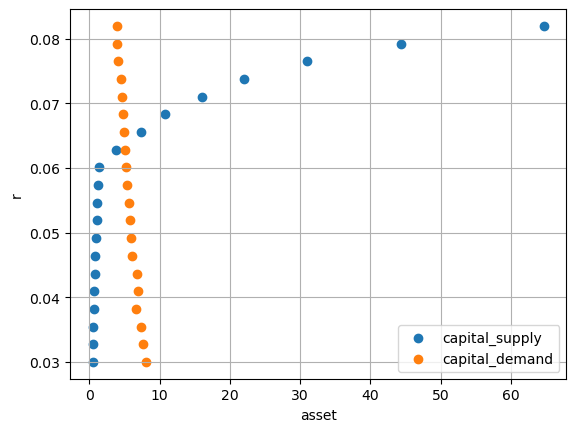

In [28]:
# Plot
plt.scatter(capital_supply,rgrid,label="capital_supply")
plt.scatter(capital_demand,rgrid,label="capital_demand")
# plt.title('capital market with w=0.8375')
plt.ylabel('r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

In [31]:
rgrid

array([0.03      , 0.03273684, 0.03547368, 0.03821053, 0.04094737,
       0.04368421, 0.04642105, 0.04915789, 0.05189474, 0.05463158,
       0.05736842, 0.06010526, 0.06284211, 0.06557895, 0.06831579,
       0.07105263, 0.07378947, 0.07652632, 0.07926316, 0.082     ])

## iteration

In [36]:
# nested bisection old version
def r_iteration(tol):
    rmin=0.06284211
    rmax=0.06557895
    r0=1/2*(rmin+rmax)
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        w = w_update(r0)
        res_k = equilibrium_k(w,r0)
        if res_k < 0:
            rmin=r0
        else:
            rmax=r0
        r0 = 1/2*(rmin+rmax)
        error = np.abs(rmax-rmin)
        count = count + 1
        print('rmin=',rmin,'rmax=',rmax,'r=',r0,'iteration times=',count,'res_k=',res_k)
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return r0 

In [37]:
start_time = timeit.default_timer()
r_eq = r_iteration(1e-5)
print("The time difference is :", timeit.default_timer() - start_time)

w= 0.5 r=, 0.06421053 labor supply= 0.6789060900123042 labor demand= 27.086174664812155 res_l= -26.40726857479985
w= 1.5 r=, 0.06421053 labor supply= 0.9927472431152159 labor demand= 0.09281343834987817 res_l= 0.8999338047653377
w= 1.0 r=, 0.06421053 labor supply= 0.9553508384448391 labor demand= 1.2111924937667093 res_l= -0.2558416553218702
w= 1.25 r=, 0.06421053 labor supply= 0.9798380195799886 labor demand= 0.36066527093883577 res_l= 0.6191727486411529
w= 1.125 r=, 0.06421053 labor supply= 0.969635966613673 labor demand= 0.6602239718865701 res_l= 0.3094119947271029
w= 1.0625 r=, 0.06421053 labor supply= 0.9606730028668473 labor demand= 0.9245606776555308 res_l= 0.036112325211316465
w= 1.03125 r=, 0.06421053 labor supply= 0.960673003586739 labor demand= 1.021296866292322 res_l= -0.060623862705583065
w= 1.046875 r=, 0.06421053 labor supply= 0.9606730003971454 labor demand= 0.9713650772083572 res_l= -0.01069207681121176
w= 1.0546875 r=, 0.06421053 labor supply= 0.9606729991084957 labor

In [38]:
w_eq = w_update(r_eq)

w= 0.5 r=, 0.0641437126171875 labor supply= 0.6789060900123044 labor demand= 27.10700347427202 res_l= -26.428097384259715
w= 1.5 r=, 0.0641437126171875 labor supply= 0.9927472431152164 labor demand= 0.09288481031164923 res_l= 0.8998624328035673
w= 1.0 r=, 0.0641437126171875 labor supply= 0.9553508382873118 labor demand= 1.212123885708288 res_l= -0.2567730474209763
w= 1.25 r=, 0.0641437126171875 labor supply= 0.9798380195799885 labor demand= 0.360942616422284 res_l= 0.6188954031577045
w= 1.125 r=, 0.0641437126171875 labor supply= 0.9696359656425942 labor demand= 0.660731697627295 res_l= 0.30890426801529924
w= 1.0625 r=, 0.0641437126171875 labor supply= 0.9606730028668464 labor demand= 0.9252716491539887 res_l= 0.035401353712857686
w= 1.03125 r=, 0.0641437126171875 labor supply= 0.9606730033741347 labor demand= 1.0220822330890433 res_l= -0.061409229714908586
w= 1.046875 r=, 0.0641437126171875 labor supply= 0.9606729997903216 labor demand= 0.9721120589787215 res_l= -0.011439059188399936
w

In [39]:
equilibrium_l(w_eq,r_eq)

w= 1.0506057739257812 r=, 0.0641437126171875 labor supply= 0.9606730031352523 labor demand= 0.9606527637272572 res_l= 2.0239407995115144e-05


2.0239407995115144e-05

In [40]:
equilibrium_k(w_eq,r_eq)


w= 1.0506057739257812 r=, 0.0641437126171875 capital supply= 4.958073945660268 capital demand= 4.9774472404158425 res_k= -0.019373294755574477


-0.019373294755574477

In [41]:
from tqdm import tqdm

def labor_curve(n_a, wmin, wmax, wgrid_number,r):
    wgrid = np.linspace(wmin, wmax, wgrid_number)
    l_supply = np.zeros(wgrid_number)
    l_demand = np.zeros(wgrid_number)
    for i in tqdm(range(wgrid_number)):
        w0 = wgrid[i]
        capital_supply,capital_demand,l_supply[i],l_demand[i]=capital_and_labor(w0,r) #capital 只是为了占位
    return wgrid, l_supply, l_demand

wgrid, labor_supply, labor_demand = labor_curve(
    n_a=n_k, wmin=0.5, wmax=1.5, wgrid_number=50,r=r_eq
)

100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


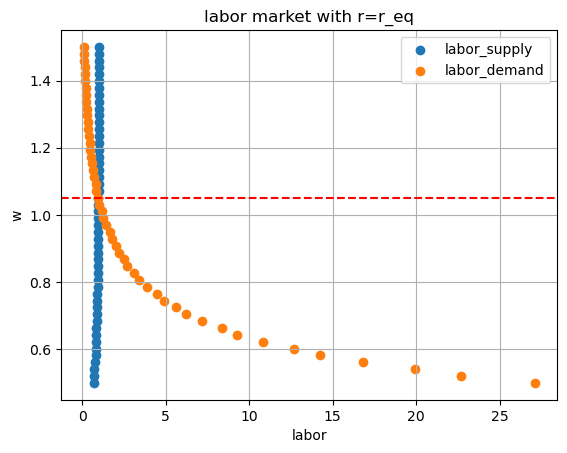

In [42]:
# Plot
plt.scatter(labor_supply,wgrid,label="labor_supply")
plt.scatter(labor_demand,wgrid,label="labor_demand")
plt.title('labor market with r=r_eq')
plt.ylabel('w')
plt.xlabel('labor')
plt.axhline(w_eq,ls='--',color='r')
plt.legend()
plt.grid(True)

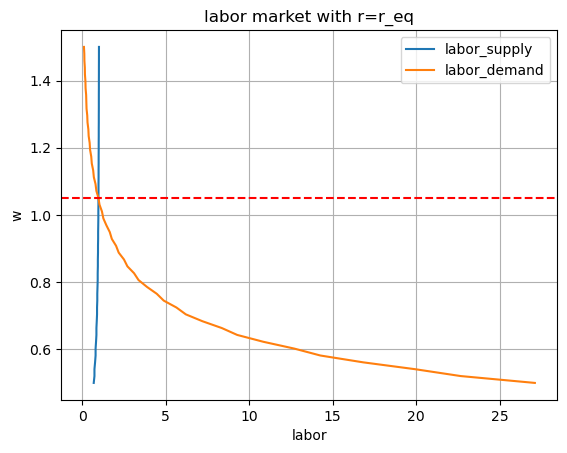

In [43]:
# Plot
plt.plot(labor_supply,wgrid,label="labor_supply")
plt.plot(labor_demand,wgrid,label="labor_demand")
plt.title('labor market with r=r_eq')
plt.ylabel('w')
plt.xlabel('labor')
plt.axhline(w_eq,ls='--',color='r')
plt.legend()
plt.grid(True)

In [44]:
from tqdm import tqdm

def capital_curve(n_a, rmin, rmax, rgrid_number,w):
    rgrid = np.linspace(rmin, rmax, rgrid_number)
    a_supply = np.zeros(rgrid_number)
    a_demand = np.zeros(rgrid_number)
    for i in tqdm(range(rgrid_number)):
        r0 = rgrid[i]
        a_supply[i],a_demand[i],l_supply,l_demand=capital_and_labor(w,r0) #labor 只是为了占位
    return rgrid, a_supply, a_demand

rgrid, capital_supply, capital_demand = capital_curve(
    n_a=n_k, rmin=0.03, rmax=0.082, rgrid_number=50,w=w_eq
)


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


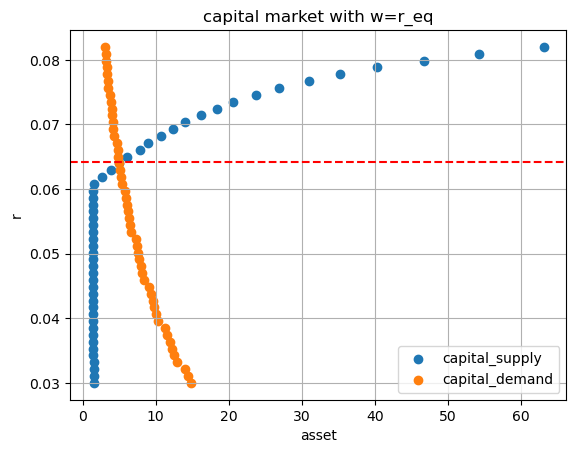

In [45]:
# Plot
plt.scatter(capital_supply,rgrid,label="capital_supply")
plt.scatter(capital_demand,rgrid,label="capital_demand")
plt.title('capital market with w=r_eq')
plt.ylabel('r')
plt.xlabel('asset')
plt.axhline(r_eq,ls='--',color='r')
plt.legend()
plt.grid(True)

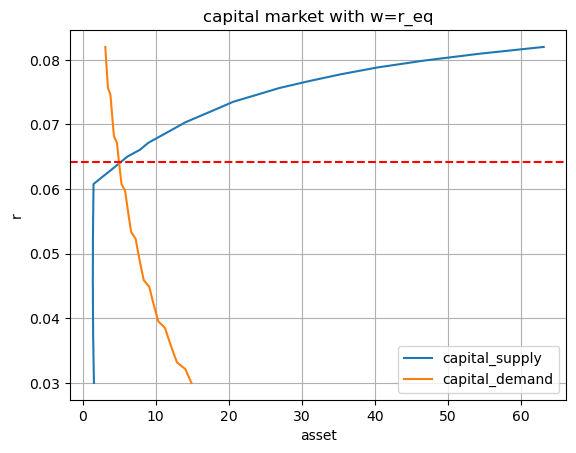

In [46]:
# Plot
plt.plot(capital_supply,rgrid,label="capital_supply")
plt.plot(capital_demand,rgrid,label="capital_demand")
plt.title('capital market with w=r_eq')
plt.ylabel('r')
plt.axhline(r_eq,ls='--',color='r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

## goods market recheck

In [59]:
def goods(w,r):
    R = r+delta
    V0 = np.zeros((n_k, n_z))
    V_new,g,state_entrepreneur=V_iteration(V0,1e-7,w,r)
    state_worker=np.ones((n_k , n_z))-state_entrepreneur
    Q=transQ_sparse(g)
    psi0 = np.ones((n_k * n_z))/(n_k * n_z)
    ss=sparse_stationary_distribution_iteration(Q,psi0,10e-5)
    tmp = ss.reshape((n_k, n_z))
    a_dist=capital_marginal(ss)
    z_dist=state_marginal(ss)
    goods_demand_joint = np.zeros((n_k, n_z))
    goods_supply_joint = np.zeros((n_k, n_z))
    capital_joint = np.zeros((n_k,n_z))        
    fixed_cost_joint = np.zeros((n_k,n_z))      
    for i_k in range(n_k):
        for i_z in range(n_z):
            k = ((R / alpha / zgrid[i_z]) * (w * alpha / R / theta) ** theta) ** (1 / (alpha + theta - 1))
            l = k * (theta / alpha) * (R / w)
            goods_demand_joint[i_k,i_z]=(state_entrepreneur[i_k,i_z]*budget_entrepreneur(i_z,k,l,kgrid[i_k], g[i_k,i_z], w, r)+state_worker[i_k,i_z]*budget_worker(kgrid[i_k], g[i_k,i_z], w, r))*tmp[i_k,i_z]
            goods_supply_joint[i_k,i_z]=state_entrepreneur[i_k,i_z]*(zgrid[i_z]*(k**alpha)*(l**theta))*tmp[i_k,i_z]
            capital_joint[i_k,i_z]=state_entrepreneur[i_k,i_z]*k*tmp[i_k,i_z]
            fixed_cost_joint[i_k,i_z]=state_entrepreneur[i_k,i_z]*tmp[i_k,i_z]*fc_m
    goods_demand = np.sum(goods_demand_joint)
    goods_supply = np.sum(goods_supply_joint)
    capital = np.sum(capital_joint)
    fixed_cost = np.sum(fixed_cost_joint)
    return goods_supply,goods_demand,capital,fixed_cost

In [60]:
goods_supply,goods_demand,capital,fixed_cost=goods(w_eq,r_eq)

In [61]:
print('goods supply=',goods_supply,'goods demand=',goods_demand,'capital supply=',capital,'fixed cost=',fixed_cost)

goods supply= 2.0597292659379907 goods demand= 1.569439130946358 capital supply= 4.9774472404158425 fixed cost= 0.18405034532703038


In [62]:
goods_supply-goods_demand-delta*capital-(1+r_eq)*fixed_cost

-0.004212717218099432